# Aloha Ship and Pack - Mililani

## Setup

### File Paths

In [2]:
TRANSACTIONS_2019 = 'data/records_2019_trimmed.csv'
TRANSACTIONS_2020 = 'data/records_2020_trimmed.csv'
TRANSACTIONS_2021 = 'data/records_2021_trimmed.csv'
YEARS_COVERED = '2019 to 2021'
DEPARTMENTS  = 'data/sku_to_departments.csv'

### Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

### Load CSVs into Dataframes

In [4]:
def load_csvs():
    transactions = pd.read_csv(TRANSACTIONS_2019)
    for each in [TRANSACTIONS_2020, TRANSACTIONS_2021]:
        t_df = pd.read_csv(each)
        transactions = transactions.append(t_df)

    transactions.reset_index(drop=True, inplace=True)
    sku2department = pd.read_csv(DEPARTMENTS)
    
    del(t_df)
    return transactions, sku2department


### Clean transactions dataframe

In [5]:
def clean_dataframe(trans_df):
    #column names
    cols_dict = {
        'Payment Method' : 'Payment_Method',
        'Department' : 'Item_Name',
        'Unit Price' : 'Unit_Price',
        'Disc' : 'Discount',
        'Ext Price' : 'Extended_Price',
        'Sub-Total:' : 'Sub_Total',
        'Sales Tax:' : 'Sales_Tax',
        'Invoice Total:' : 'Invoice_Total',
    }
    trans_df.rename(columns=cols_dict, inplace=True)

    #remove $ signs and commas
    print("Removing $ signs and commas")
    cols_to_strip = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Invoice_Total']
    for col in cols_to_strip:
        trans_df[col] = trans_df[col].apply(lambda x: x.replace('$', ''))
        trans_df[col] = trans_df[col].apply(lambda x: x.replace(',', ''))

    #make (###) into -###
    trans_df.reset_index(drop=True, inplace=True)
    print('converting negative numbers to numerical type string')
    cols_to_sign = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Invoice_Total']
    for col in cols_to_sign:
        idxs_to_change = trans_df[col].str.contains("(", regex=False).to_numpy().nonzero()[0]
        for i in idxs_to_change:
            cell = "-" + trans_df.at[i,col][1:-1]
            trans_df.at[i,col] = cell

    #change types to float
    print('changing numberical types to float')
    cols_to_float = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Sales_Tax', 'Invoice_Total']
    for col in cols_to_float:
        trans_df[col] = trans_df[col].astype(float)

    #combine date and time into a datetime object instead of just strings
    trans_df['DateTimeStamp'] = pd.to_datetime(trans_df.Date + " " + trans_df.Time)
    trans_df['DateStamp'] = pd.to_datetime(trans_df.Date)

    #drop original columns so its not confusing
    trans_df.drop(['Date', 'Time'], axis=1, inplace=True)
    
    return trans_df
    

In [6]:
def merge_dfs(trans_df, sku2dept_df):
    ## Merge department names from Inventory list into the transactions listing
    trans_df = pd.merge(trans_df, sku2dept_df[['SKU', 'Department']], 
                how='left', left_on='SKU', right_on='SKU')

    #create a transaction id/key
    trans_df['transaction_id'] = range(1, len(trans_df)+1)

    return trans_df


In [7]:
def missing_dept_records(trans_df):
    #Address missing SKU2Department Records that leave an NA in Department
    missing_idxs = trans_df.Department.isna().to_numpy().nonzero()[0]

    for i in missing_idxs:
        cell = trans_df.at[i, 'SKU']
        if 'FEDEX' in cell or 'OAHU-GND' in cell:
            trans_df.at[i, 'Department'] = 'FEDEX'
        elif 'USPS' in cell or 'FIRSTCLASS' in cell or 'FirstClass' in cell:
            trans_df.at[i, 'Department'] = 'USPS'
        elif 'DHL' in cell:
            trans_df.at[i, 'Department'] = 'DHL'
        elif 'MBDWCLUTCH' in cell or 'MBDVOTIVE' in cell:
            trans_df.at[i, 'Department'] = 'RETAIL' 
        elif 'WWXSVR' in cell:
            trans_df.at[i, 'Department'] = 'UPS'

    # Single letter items
    fl = ['F3.5', 'F5', 'F3', 'F2', 'F4', 'F1', 'F10', 
            'F6', 'F9', 'F7', 'F8', 'F11', 'F12', 'F13']
    ml = ['M2','M3']
    pl = ['P4', 'P3', 'P5', 'P12', 'P3.5','P1', 'P2', 
            'P6', 'P7', 'P9', 'P8', 'P10', 'P11']

    trans_df.loc[(trans_df.SKU.isin(fl)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(ml)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(pl)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(['MBXR', 'MBX'])), 'Department'] = 'MAILBOX'
        
    post_missing_idxs = trans_df.Department.isna().to_numpy().nonzero()[0]
    print("# of Missing department records to get dropped: ", len(post_missing_idxs))

    #drop remaining NAs
    trans_df.dropna(inplace=True)

    return trans_df

## Load/Reload Dataframes

In [8]:
if 'transactions' in locals() or 'transactions' in globals():
    print('deleting transactions dataframe')
    del transactions

transactions, sku2department = load_csvs()
transactions = clean_dataframe(transactions)
transactions = merge_dfs(transactions, sku2department)
transactions = missing_dept_records(transactions)

Removing $ signs and commas
converting negative numbers to numerical type string
changing numberical types to float
# of Missing department records to get dropped:  25


## Visualizations

### Transactions by Volume and total sales amount

In [49]:
info = pd.DataFrame(transactions.Department.value_counts())
info.reset_index(inplace=True)
info.columns = ['Department', 'Counts']

#Departments by sales volume
sales_volume = []
for dept in transactions.Department.unique():
    t_s = transactions[transactions.Department == dept]['Extended_Price']
    t_s = int(sum(t_s))
    sales_volume.append( (dept,t_s) )

sv_df = pd.DataFrame(sales_volume)
sv_df.columns = ['Department', 'Total_Sales']

counts_total_sales_df = pd.merge(info, sv_df, how='outer', left_on='Department', right_on='Department')

#created 'normed' sales volume so it doesnt throw off the graph
sales_max = counts_total_sales_df.Total_Sales.max()
counts_max = counts_total_sales_df.Counts.max()

counts_total_sales_df['normed_total_sales'] = counts_total_sales_df.Total_Sales / sales_max
counts_total_sales_df['normed_total_sales'] = (counts_total_sales_df['normed_total_sales'] * counts_max).astype(int)

#drop MISC NON TAX as its not really a sales item and its vague
idx = counts_total_sales_df[counts_total_sales_df.Department == 'MISC NON TAX'].index
counts_total_sales_df.drop(idx, inplace=True)

#remove negatives as its throwing off the graph and not very informational
counts_total_sales_df.loc[(counts_total_sales_df.normed_total_sales < 0), 'normed_total_sales'] = 0


In [12]:
counts_total_sales_df

,Department,Counts,Total_Sales,normed_total_sales
0,USPS,21317,413180,21317
1,COPIES,13155,87635,4521
2,RETAIL,11783,119245,6152
3,NOTARY,6799,101348,5228
4,FAX,4276,23108,1192
5,METER,4228,13914,717
7,FEDEX,2262,255359,13174
8,CARDS,1049,8533,440
9,PACK,747,11609,598
10,UPS,706,114870,5926


Text(0.5, 1.0, 'By Number of Transactions')

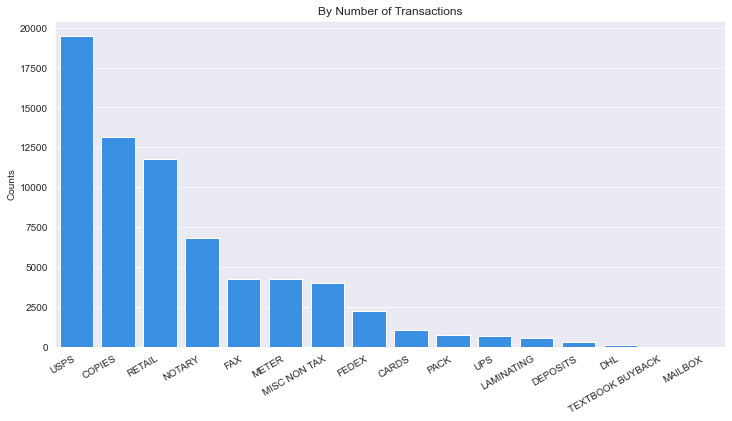

In [132]:
#Departments by number of transactions 
sns.set_style('darkgrid')
plt.figure(figsize = (12,6))
ax = sns.barplot(data = counts_total_sales_df, x='Department', y='Counts', color='dodgerblue')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'right')
ax.set_xlabel('')
plt.title("By Number of Transactions")


Text(0.5, 1.0, 'By Sales Volume')

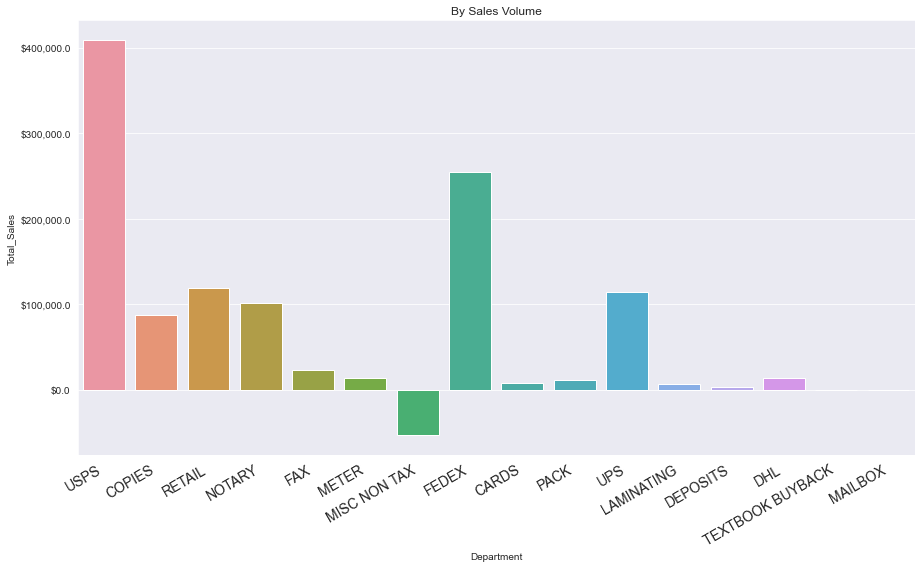

In [134]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,8))
ax = sns.barplot(data = counts_total_sales_df, x='Department', y='Total_Sales')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, ha = 'right', size = 14)
ax.yaxis.set_major_formatter('${x:,}')
# ax.set_yticklabels(ax.get_yticklabels(), size = 14)
plt.title("By Sales Volume")

### Combined Graph

/var/folders/yz/6drrhg0x63596m99cvrlz3xc0000gp/T/ipykernel_3377/3486230730.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax2.set_yticklabels(["$0", "$115,000", "$230,000", "$345,000", "$465,000"])


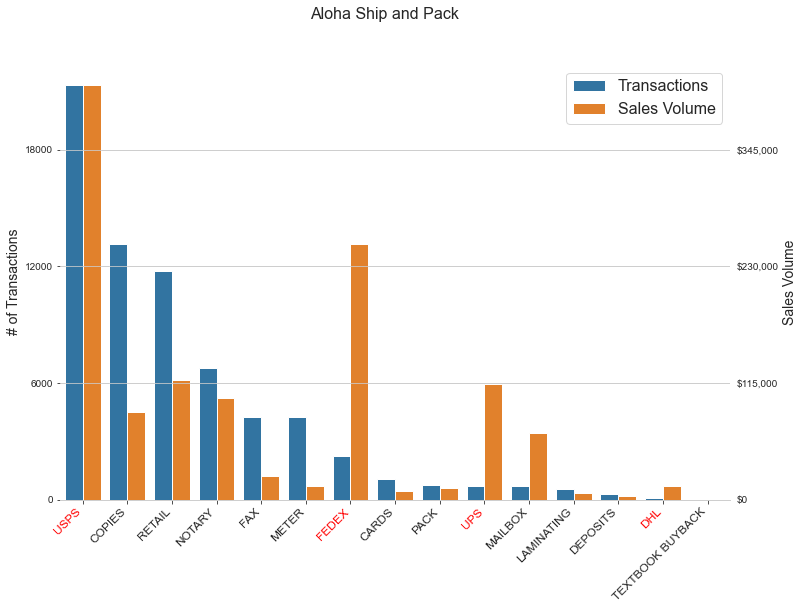

In [51]:
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
info_df = counts_total_sales_df[['Department', 'Counts', 'normed_total_sales']]
info_melt = pd.melt(info_df, id_vars="Department")

sns.set_style('whitegrid')
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

b = sns.barplot(x='Department', y='value', hue='variable', data=info_melt)

###adjust the look of the plot
## x-axis
x_tick_labels = ax1.xaxis.get_ticklabels()
_ = ax1.xaxis.set_ticklabels(x_tick_labels, rotation = 45, ha = 'right', size = BASE_FONT_SIZE-2)
_ = ax1.xaxis.set_label_text("")


#colorize the x labels
shipping_companies = ['USPS', 'UPS', 'FEDEX', 'DHL']
for tick in x_tick_labels:
    tick_text = tick.get_text()
    if tick_text in shipping_companies : tick.set_color('red')

## y-axis
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
_ = ax1.yaxis.set_label_text("# of Transactions")
ax1.yaxis.label.set_fontsize(BASE_FONT_SIZE)

#right side y-axis
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
_ = ax2.set_yticklabels(["$0", "$115,000", "$230,000", "$345,000", "$465,000"])
ax2.set_ylabel('Sales Volume', fontsize=BASE_FONT_SIZE)

#adjust the legend
ax1.legend(fontsize = TITLE_FONT_SIZE)

# legend.set_title('')
for t, l in zip(ax1.legend_.texts, ('Transactions', "Sales Volume")):
    t.set_text(l)

# other
ax1.tick_params(bottom=True)
ax2.tick_params(left=False, right=False)
sns.despine(left=True, bottom=False, right=True)
fig.suptitle("Aloha Ship and Pack", fontsize=TITLE_FONT_SIZE)

plt.savefig('figures/trans_by_sales-volume.jpg', bbox_inches='tight')
plt.show()

### Historgram of shipping companies

In [9]:
#data
usps_trans  = transactions[(transactions.Department == 'USPS') & (transactions.Extended_Price > 0)]['Extended_Price']
fedex_trans = transactions[(transactions.Department == 'FEDEX') & (transactions.Extended_Price > 0)]['Extended_Price']
dhl_trans   = transactions[(transactions.Department == 'DHL') & (transactions.Extended_Price > 0)]['Extended_Price']

usps_avg  = np.average(usps_trans)
fedex_avg = np.average(fedex_trans)
dhl_avg   = np.average(dhl_trans)

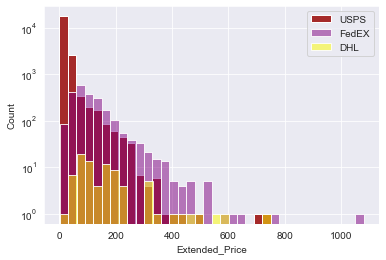

In [174]:
EDGE_C = '1'
LINE_W = '1'
BIN_WDTH = 30


b = sns.histplot()
sns.histplot(data = usps_trans, color='brown', alpha=1, bins=20, label='USPS', binwidth=BIN_WDTH)
sns.histplot(data = fedex_trans, color='purple', bins=20, label='FedEX', alpha = 0.5, binwidth=BIN_WDTH)
sns.histplot(data = dhl_trans, color='yellow', bins=10, label='DHL', alpha = 0.5, binwidth=BIN_WDTH)
b.set_yscale('log')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

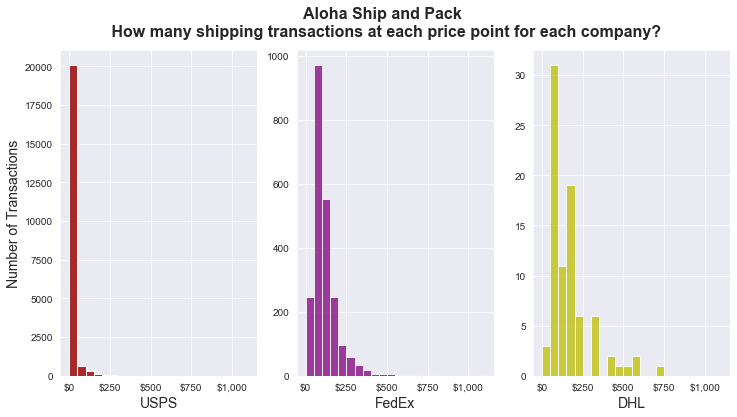

In [47]:
EDGE_C = '1'
LINE_W = '1'
BASE_FONT_SIZE = 14
BIN_WDTH = 50

plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=False, sharex=True)
ax1, ax2, ax3 = axes

#plots
sns.histplot(ax=ax1, 
            data = usps_trans, label='USPS',
            color='brown', alpha=1, bins=20,  binwidth=BIN_WDTH)
sns.histplot(ax=ax2, 
            data = fedex_trans, label='FedEX',
            color='purple', bins=20, binwidth=BIN_WDTH)
sns.histplot(ax=ax3, data = dhl_trans, 
            color='y', bins=10, label='DHL', binwidth=BIN_WDTH)

#xaxis
ax1.xaxis.set_label_text('USPS', fontsize=BASE_FONT_SIZE)
ax2.xaxis.set_label_text('FedEx', fontsize=BASE_FONT_SIZE)
ax3.xaxis.set_label_text('DHL', fontsize=BASE_FONT_SIZE)

ax1.xaxis.set_major_formatter('${x:,.0f}')

#yaxis
ax1.yaxis.set_label_text("Number of Transactions", fontsize=BASE_FONT_SIZE)
ax2.yaxis.set_label_text("")
ax3.yaxis.set_label_text("")

#other
sns.set_style('darkgrid')
fig.suptitle('Aloha Ship and Pack \n How many shipping transactions at each price point for each company?', fontsize=16, fontweight='bold')
# plt.title("thing")

plt.savefig("figures/shipping_trans.jpg")
plt.show()


### What do customers buy during their first named transaction?

? what if they buy multiple things together?  Consider each one a first transaction as long as its on the same date?

In [58]:
customers = list(transactions.Customer.unique())
customers.pop(customers.index('Cash, Check, Charge'))

first_transactions = transactions.sort_values(by=['Customer','DateStamp']).groupby('Customer').head(1)
first_transactions = first_transactions[['Customer', 'DateStamp']]


In [69]:
for customer in customers:
    first_transactions[first_transactions.Customer == customer]

,Customer,DateStamp
580,1016 Properties,2019-01-11
66913,102d Mp Det (cid),2021-10-25
56286,19th Mp Bn (cid),2021-05-11
55796,2 Thumbs Tattoo,2021-05-04
30190,"Abalos, Amirose",2020-06-05


In [68]:
def write_first_transactions_to_file(first_trans):
    with open('output.txt', 'w') as f:
        for line in first_trans:
            output_line = ""
            for element in line:
                output_line = output_line + element + ' '
            output_line = output_line[:-1] + '\n'
            f.writelines(output_line)

# Scratchpad area below

### Trying to clean up all the remaining skus without department

In [185]:
df.loc[(df.Event == 'Dance'),'Event']='Hip-Hop'

In [14]:
transactions_copy = transactions.copy()

In [33]:
transactions = transactions_copy.copy()

In [58]:
df = pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
})

df.head()

,Factor,Weight,Variance
0,Growth,0.1,0.15
1,Value,0.2,0.35


In [59]:
tidy = df.melt(id_vars='Factor').rename(columns=str.title)
tidy.head()

,Factor,Variable,Value
0,Growth,Weight,0.10
1,Value,Weight,0.20
2,Growth,Variance,0.15
3,Value,Variance,0.35


### Trying to make sure the groupby and sort thing works
 to grab the first transaction from each unique customer

In [80]:
small_transactions = transactions[transactions.Customer == 'Mahfet, Sherryl']
small_transactions = small_transactions.append(transactions[transactions.Customer == 'Chapman, Derek'])
small_transactions = small_transactions.append(transactions[transactions.Customer == 'Spray, William'])
small_transactions.sort_index(inplace=True)

In [101]:
small_transactions[['Customer', 'DateStamp']].head(30)

,Customer,DateStamp
11866,"Chapman, Derek",2019-08-05
11867,"Chapman, Derek",2019-08-05
32512,"Mahfet, Sherryl",2020-07-08
46804,"Mahfet, Sherryl",2021-01-05
46805,"Mahfet, Sherryl",2021-01-05
52953,"Chapman, Derek",2021-03-29
58517,"Chapman, Derek",2021-06-15
58518,"Chapman, Derek",2021-06-15
59101,"Mahfet, Sherryl",2021-06-24
70555,"Chapman, Derek",2021-12-13


In [102]:
# transactions.sort_values(by='DateStamp').groupby('Customer', sort=False).head(30)
first_transactions = small_transactions.sort_values(by=['Customer','DateStamp']).groupby('Customer').head(1) #.sort_values(by='DateStamp').head(30)

In [106]:
first_transactions
cust = first_transactions.Customer
first_date = first_transactions.DateStamp

list(zip(cust, first_date))

[('Chapman, Derek', Timestamp('2019-08-05 00:00:00')),
 ('Mahfet, Sherryl', Timestamp('2020-07-08 00:00:00')),
 ('Spray, William', Timestamp('2021-12-24 00:00:00'))]

In [60]:
### export list of lists to a space seperated file

In [63]:
test_data = [['a', 'b', 'c', 'd', 'e'],
             ['b', 'b', 'b', 'd', 'e'],
             ['b', 'b', 'b', 'd', 'e']]

In [78]:
transactions.reset_index(drop=True, inplace=True)

In [109]:
small_trans = transactions.loc[0:1000, :]

customers = list(small_trans.Customer.unique())
# customers.pop(customers.index('Cash, Check, Charge'))

first_transactions = small_trans.sort_values(by=['Customer','DateStamp']).groupby('Customer').head(1)
first_transactions = first_transactions[['Customer', 'DateStamp']]

In [110]:
# first_transactions['transactions'] = ''

all_trans = []
for customer in customers:
    # customer = customers[0]
    cust_first_date = first_transactions[first_transactions.Customer == customer]['DateStamp']
    cust_first_date = cust_first_date.item()

    tdf = transactions.loc[(transactions.Customer == customer) & (transactions.DateStamp == cust_first_date)]
    cust_trans = tdf['Department'].tolist()
    all_trans.append(cust_trans)

In [111]:
print(len(all_trans))
print(len(first_transactions))
len(all_trans) == len(first_transactions)

198
198


True

In [112]:
first_transactions['transactions'] = all_trans

In [113]:
first_transactions

,Customer,DateStamp,transactions
577,1016 Properties,2019-01-11,"[METER, RETAIL, METER, COPIES, FAX, FAX, COPIE..."
271,"Acosta, Luis",2019-01-07,"[NOTARY, USPS, USPS]"
661,"Adams, Ethel",2019-01-14,"[USPS, USPS]"
435,"Afuso-doi, Mary",2019-01-09,[USPS]
681,"Agard, Adrian",2019-01-14,"[USPS, USPS, MISC NON TAX]"
...,...,...,...
484,"Yamaguchi, Cody",2019-01-09,[USPS]
590,"Yamasato, Charleen",2019-01-11,"[USPS, USPS]"
360,"Yandell, Diane",2019-01-08,"[RETAIL, USPS]"
797,"Yi, Yong",2019-01-15,[USPS]


In [116]:
small_trans.loc[(small_trans.Customer == 'Yorimoto, Lindsey') & (small_trans.DateStamp == '2019-01-12')]

,Customer,Payment_Method,SKU,Item_Name,QTY,Unit_Price,Discount,Extended_Price,Sub_Total,Sales_Tax,Invoice_Total,DateTimeStamp,DateStamp,Department,transaction_id
651,"Yorimoto, Lindsey",CASH,DOCSHRED,Document Shredding (per Lb),4,1.00,10.00%,3.60,41.77,1.97,43.74,2019-01-12 13:33:00,2019-01-12,RETAIL,656
652,"Yorimoto, Lindsey",CASH,B&W REG,Black & White Standard Copy,184,0.15,10.00%,24.84,41.77,1.97,43.74,2019-01-12 13:33:00,2019-01-12,COPIES,657
653,"Yorimoto, Lindsey",CASH,USPS-PRI,Priority Mail,1,14.81,10.00%,13.33,41.77,1.97,43.74,2019-01-12 13:33:00,2019-01-12,USPS,658


In [90]:
cust_first_date.item()

Timestamp('2019-01-02 00:00:00')

In [91]:
print(type(cust_first_date.item()))
print("")
print(type(transactions.DateStamp[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [52]:
413180/21317


19.382652343200263

In [75]:
# plt1.axes.yaxis.get_ticks()
# plt1.axes.yaxis.get_ticks_position()
# (ax2.yaxis.get_ticklabels())
# ( / counts_max * sales_max, 1)
(np.array(ax2.get_yticks()) / counts_max * sales_max).astype(int)
[0, 115000, 230000, 345_000, 465_000]


array([     0, 116295, 232591, 348887, 465183])

In [158]:
usps_avg

19.382656096073557